In [23]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from arch import arch_model
from tqdm import tqdm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# # This time Load in ONLY past 20 years worth of daily OHLCV stock data of ONLY THE S&P 500 directly and not each stock individually 
# ticker = '^GSPC'
# df = yf.download(ticker, period='20y')
# df.reset_index(inplace=True)
# df.columns = df.columns.str.lower()
# df.set_index('date', inplace=True)
# df = df[['open', 'high', 'low', 'close', 'volume']]
# df['log_returns'] = np.log(df['close']).diff()


#### Load in all of the Volatility Metrics

In [3]:
# volatility_window_size = '3D' # In DAYS not Datapoints

# # Close to Close Volatility 
# def calculate_ctc_vol(data, window_size = volatility_window_size):
#     def ctc(returns): 
#         T = len(returns) 
#         return np.sqrt((1/(T - 1)) * np.sum(np.square(returns - np.mean(returns))))
#     return data.dropna().rolling(window=window_size, min_periods=2).apply(ctc)

# df['ctc_vol'] = calculate_ctc_vol(df["log_returns"])

# # Parkinson Volatility
# def calculate_parkinson_vol(data, df = df, window_size = volatility_window_size):
#     def parkinson(rolling_window, df):
#         df_roll = df.loc[rolling_window.index]
#         T = len(df_roll)
#         high_lo_ratio = df_roll['high'] / df_roll['low']
#         return np.sqrt((1/(4 * T * np.log(2))) * np.sum(np.square(np.log(high_lo_ratio))))
#     return data.dropna().rolling(window=window_size, min_periods=1).apply(parkinson, args=(df,))['high']

# df['parkinson_vol'] = calculate_parkinson_vol( df[['high', 'low']])


# # Garman Klass Volatility
# def calculate_garman_klass_vol(data, df = df, window_size = volatility_window_size):
#     def garman_klass(rolling_window, df):
#         df_roll = df.loc[rolling_window.index]
#         T = len(df_roll)
#         high_lo_ratio = df_roll['high'] / df_roll['low']
#         close_open_ratio = df_roll['close'] / df_roll['open']
#         return np.sqrt((1 / (2 * T)) * np.sum(np.square(np.log(high_lo_ratio)) - (((2* np.log(2) - 1)/T) * np.square(np.log(close_open_ratio)))))
#     return data.dropna().rolling(window=window_size, min_periods=1).apply(garman_klass, args=(df,))['high']

# df['garman_klass_vol'] = calculate_garman_klass_vol( df[['high', 'low', 'close', 'open']])

# # Rodger Satchell Volatility
# def calculate_rogers_satchell_vol(data, df = df, window_size = volatility_window_size):
#     def rogers_satchell(rolling_window, df):
#         df_roll = df.loc[rolling_window.index]
#         T = len(df_roll)
#         high_close_ratio = df_roll['high'] / df_roll['close']
#         high_open_ratio = df_roll['high'] / df_roll['open']
#         lo_close_ratio = df_roll['high'] / df_roll['close']
#         lo_open_ratio = df_roll['high'] / df_roll['open']
#         log_sum = np.sum(np.log(high_close_ratio) * np.log(high_open_ratio) + np.log(lo_close_ratio) * np.log(lo_open_ratio))
#         return np.sqrt((1/T) * log_sum)
#     return data.dropna().rolling(window=window_size, min_periods=1).apply(rogers_satchell, args=(df,))['high']
# df['rogers_satchell_vol'] = calculate_rogers_satchell_vol( df[['high', 'low', 'close', 'open']])

# # Yang Zhang Volatility
# def calculate_yang_zhang_vol(data, df = df, window_size = volatility_window_size, alpha = 1.34):
#     # Doing some research this alpha comes from empirical testing in the paper but maybe we try using different values 
#     def yang_zhang(rolling_window, df):
#         df['prev_close'] = df['close'].shift(1)
#         df_roll = df.loc[rolling_window.index]
        
#         T = len(df_roll)
#         k = (alpha - 1)/ (alpha + ((T + 1) / (T - 1)))

#         high_close_ratio = df_roll['high'] / df_roll['close']
#         high_open_ratio = df_roll['high'] / df_roll['open']
#         lo_close_ratio = df_roll['high'] / df_roll['close']
#         lo_open_ratio = df_roll['high'] / df_roll['open']
#         overnight_open_close_ratio = df_roll['open'] / df_roll['prev_close']
#         close_open_ratio = df_roll['close'] / df_roll['open']
        
#         overnight_volatility =(1 / (T - 1)) * np.sum(np.square(np.log(overnight_open_close_ratio) - np.mean(np.log(overnight_open_close_ratio))))
#         open_to_close_volatility = (1 / (T - 1)) * np.sum(np.square(np.log(close_open_ratio) - np.mean(np.log(close_open_ratio))))
#         log_sum = np.sum(np.log(high_close_ratio) * np.log(high_open_ratio) + np.log(lo_close_ratio) * np.log(lo_open_ratio))
#         rodger_satchell_sqr = (1/T) * log_sum
        
#         del df['prev_close']
#         return np.sqrt(overnight_volatility + k * open_to_close_volatility + (1 - k) * rodger_satchell_sqr)
#     return data.dropna().rolling(window=window_size, min_periods=2).apply(yang_zhang, args=(df,))['high']
# df['yang_zhang_vol'] = calculate_yang_zhang_vol( df[['high', 'low', 'close', 'open']])

# df = df.reset_index()
# df.to_parquet('data/s&pwvol.parquet', engine='pyarrow')
# df

In [4]:
df = pd.read_parquet('data/s&pwvol.parquet', engine='pyarrow')
df

,date,open,high,low,close,volume,log_returns,ctc_vol,parkinson_vol,garman_klass_vol,rogers_satchell_vol,yang_zhang_vol
0,2004-05-17,1095.699951,1095.699951,1079.359985,1084.099976,1430100000,NaN,NaN,0.009024,0.009539,0.000000,NaN
1,2004-05-18,1084.099976,1094.099976,1084.099976,1091.489990,1353000000,0.006794,NaN,0.007478,0.008356,0.004683,0.005668
2,2004-05-19,1091.489990,1105.930054,1088.489990,1088.680054,1548600000,-0.002578,0.006627,0.008225,0.009499,0.012344,0.012025
3,2004-05-20,1088.680054,1092.619995,1085.430054,1089.189941,1211000000,0.000468,0.004780,0.006764,0.007892,0.012647,0.012082
4,2004-05-21,1089.189941,1099.640015,1089.189941,1093.560059,1258600000,0.004004,0.003294,0.006825,0.008005,0.013439,0.012780
...,...,...,...,...,...,...,...,...,...,...,...,...
5029,2024-05-09,5189.029785,5215.299805,5180.410156,5214.080078,3727370000,0.005078,0.002634,0.003238,0.003710,0.002694,0.003707
5030,2024-05-10,5225.490234,5239.660156,5209.680176,5222.680176,3617900000,0.001648,0.002593,0.003525,0.004055,0.003014,0.004206
5031,2024-05-13,5233.080078,5237.259766,5211.160156,5221.419922,4255710000,-0.000241,NaN,0.003000,0.003394,0.002199,NaN
5032,2024-05-14,5221.100098,5250.370117,5217.979980,5246.680176,4763580000,0.004826,0.003583,0.003377,0.003797,0.002520,0.003153


### DATA ANALYSIS

In [5]:
# df = pd.read_parquet('data/s&pwvol.parquet', engine='pyarrow')
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

# volatility_cols = ['ctc_vol', 'parkinson_vol', 'garman_klass_vol', 'rogers_satchell_vol', 'yang_zhang_vol']

# def classify_volatility(volatility_series):
#     quantiles = volatility_series.quantile([0.33, 0.66])
#     low_threshold = quantiles[0.33]
#     high_threshold = quantiles[0.66]
#     return pd.cut(volatility_series, bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['low', 'medium', 'high'])

# def classify_volatility(volatility_series):
#     quantiles = volatility_series.quantile([0.33, 0.66])
#     low_threshold = quantiles[0.33]
#     high_threshold = quantiles[0.66]
#     return pd.cut(volatility_series, bins=[-np.inf, low_threshold, high_threshold, np.inf], labels=['low', 'medium', 'high'])

# classified_volatilities = df[volatility_cols].apply(classify_volatility)

# years = range(2004, 2024 + 1)
# df['year_bin'] = pd.cut(df.index.year, bins=len(years), labels=[str(year) for year in years])

# binned_counts = classified_volatilities.groupby(df['year_bin']).apply(lambda x: x.apply(pd.Series.value_counts).unstack().fillna(0))
# fig, axes = plt.subplots(len(volatility_cols), 1, figsize=(12, 20))

# for i, col in enumerate(volatility_cols):
#     binned_data_dict = {'low': [], 'medium': [], 'high': []}

#     for year in years:
#         year_str = str(year)
#         for level in ['low', 'medium', 'high']:
#             if (year_str, col, level) in binned_counts.index:
#                 binned_data_dict[level].append(binned_counts[year_str, col, level])
#             else:
#                 binned_data_dict[level].append(0)

#     binned_data_df = pd.DataFrame(binned_data_dict, index=[str(year) for year in years])

#     ax = axes[i]
#     binned_data_df.plot(kind='bar', stacked=True, ax=ax, color=['green', 'orange', 'red'])
#     ax.set_title(f'Yearly Histogram of {col.replace("_", " ").capitalize()} Volatility')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Frequency')
#     ax.legend(title='Volatility Type', loc='upper right')

# plt.tight_layout()
# plt.show()

In [14]:
window_size = 20
buffer_size = 5
n_splits = 5
prediction_window = 3 


# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
# y_metrics = ['ctc_vol', 'parkinson_vol', 'garman_klass_vol', 'rogers_satchell_vol', 'yang_zhang_vol']
# combined_folds = [{'train': {'Xs': [np.empty((0, window_size)) for _ in y_metrics], 'ys': [np.empty((0, 1)) for _ in y_metrics]},
#                    'test': {'Xs': [np.empty((0, window_size)) for _ in y_metrics], 'ys': [np.empty((0, 1)) for _ in y_metrics]}}
#                 for _ in range(n_splits)]

folds = []
data = df

start = 0
while True: 
    end = start + window_size
    if end + 3 > len(data):
        break
    
    train_data = data.iloc[start:end]
    test_data = data.iloc[end + 3].to_frame().T 
    folds.append((train_data, test_data))
    buffer_end = end + 3 + buffer_size
    if buffer_end > len(data): 
        break
    else: 
        start = buffer_end
print(f"Number of folds generated: {len(folds)}")

indices = list(range(len(folds)))
np.random.shuffle(indices)
print(indices)
kf = KFold(n_splits=n_splits)
final_folds = []

for train_index, test_index in kf.split(indices):
    train_folds = [folds[i] for i in train_index]
    test_folds = [folds[i] for i in test_index]
    final_folds.append((train_folds, test_folds))


with open('data/time_series_folds.pkl', 'wb') as f:
    pickle.dump(final_folds, f)

Number of folds generated: 179
[131, 144, 20, 6, 7, 89, 121, 79, 153, 93, 52, 120, 115, 162, 2, 135, 40, 1, 143, 86, 68, 139, 118, 72, 94, 100, 35, 26, 37, 130, 161, 105, 165, 42, 116, 55, 173, 101, 134, 81, 95, 14, 54, 31, 126, 163, 44, 58, 96, 29, 36, 21, 43, 117, 145, 112, 122, 13, 157, 178, 28, 27, 129, 16, 62, 3, 78, 61, 32, 82, 74, 168, 109, 127, 146, 107, 138, 51, 30, 150, 49, 45, 174, 84, 56, 64, 132, 110, 83, 156, 53, 12, 50, 170, 15, 171, 128, 119, 0, 148, 88, 160, 158, 33, 164, 133, 73, 4, 8, 102, 176, 92, 63, 47, 167, 34, 123, 87, 71, 113, 24, 149, 106, 97, 111, 91, 5, 166, 23, 137, 140, 46, 65, 108, 70, 17, 41, 177, 136, 169, 125, 66, 172, 99, 124, 77, 155, 76, 90, 75, 22, 69, 175, 147, 39, 59, 85, 159, 114, 19, 9, 104, 98, 48, 57, 10, 154, 60, 152, 151, 103, 18, 141, 67, 25, 142, 38, 80, 11]


In [30]:
def historical_average(X_train):
    return np.mean(X_train, axis=1)

def ewma(X_train, span=10):
    return X_train.ewm(span=span).mean().iloc[-1]

def fit_garch(X_train):
    predictions = []
    for i in range(X_train.shape[0]): 
        garch_model = arch_model(X_train[i], vol='Garch', p=1, q=1, rescale = False)
        garch_fit = garch_model.fit(disp="off")
        forecast = garch_fit.forecast(horizon=1)
        predictions.append(forecast.variance.values[-1])

    return np.array(predictions)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

def train_lstm(X_train, y_train, X_test):
    input_dim = 1
    hidden_dim = 50
    output_dim = 1
    num_layers = 1
    num_epochs = 50
    batch_size = 1
    learning_rate = 0.001

    model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for epoch in tqdm(range(num_epochs), desc = "Training LSTM"):
        for seq, target in train_loader:
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        y_pred_test = model(X_test_tensor)

    return y_pred_train.flatten(), y_pred_test.flatten()

class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.model_dim = model_dim
        self.input_layer = nn.Linear(input_dim, model_dim)
        self.transformer = nn.Transformer(d_model=model_dim, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers)
        self.output_layer = nn.Linear(model_dim, output_dim)

    def forward(self, src, tgt):
        src = self.input_layer(src) * np.sqrt(self.model_dim)
        tgt = self.input_layer(tgt) * np.sqrt(self.model_dim)
        output = self.transformer(src, tgt)
        output = self.output_layer(output)
        return output

def train_transformer(X_train, y_train, X_test):
    input_dim = X_train.shape[1]
    model_dim = 64
    num_heads = 4
    num_layers = 2
    output_dim = 1
    num_epochs = 50
    batch_size = 1
    learning_rate = 0.001

    model = TransformerModel(input_dim, model_dim, num_heads, num_layers, output_dim)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model.train()
    for _ in tqdm(range(num_epochs), desc = "Training Transformer"):
        for src, tgt in train_loader:
            optimizer.zero_grad()
            output = model(src.unsqueeze(1), src.unsqueeze(1))
            loss = criterion(output.squeeze(-1), tgt)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_train = model(X_train_tensor.unsqueeze(1), X_train_tensor.unsqueeze(1)).squeeze(-1).cpu().numpy()
        y_pred_test = model(X_test_tensor.unsqueeze(1), X_test_tensor.unsqueeze(1)).squeeze(-1).cpu().numpy()

    return y_pred_train.flatten(), y_pred_test.flatten()

Training LSTM: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Training LSTM: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Training LSTM: 100%|██████████| 50/50 [00:09<00:00,  5

ctc_vol - Linear Average Train Errors: 8.222424619315853e-34
ctc_vol - Linear Average Test Errors: 8.423781034860396e-05
ctc_vol - Linear Average Train R^2 Scores: 1.0
ctc_vol - Linear Average Test R^2 Scores: -1.1200701587585074
ctc_vol - Decision Tree Average Train Errors: 0.0
ctc_vol - Decision Tree Average Test Errors: 6.268569495648175e-05
ctc_vol - Decision Tree Average Train R^2 Scores: 1.0
ctc_vol - Decision Tree Average Test R^2 Scores: -0.8236356011814532
ctc_vol - Ridge Average Train Errors: 9.230660548366484e-05
ctc_vol - Ridge Average Test Errors: 4.42735408759043e-05
ctc_vol - Ridge Average Train R^2 Scores: 0.11032783048889541
ctc_vol - Ridge Average Test R^2 Scores: -0.10662436882156276
ctc_vol - Lasso Average Train Errors: 0.00010480333512670145
ctc_vol - Lasso Average Test Errors: 4.646315686921295e-05
ctc_vol - Lasso Average Train R^2 Scores: 0.0
ctc_vol - Lasso Average Test R^2 Scores: -0.17263641849050773
ctc_vol - LSTM Average Train Errors: 9.819186785417512e-09
c

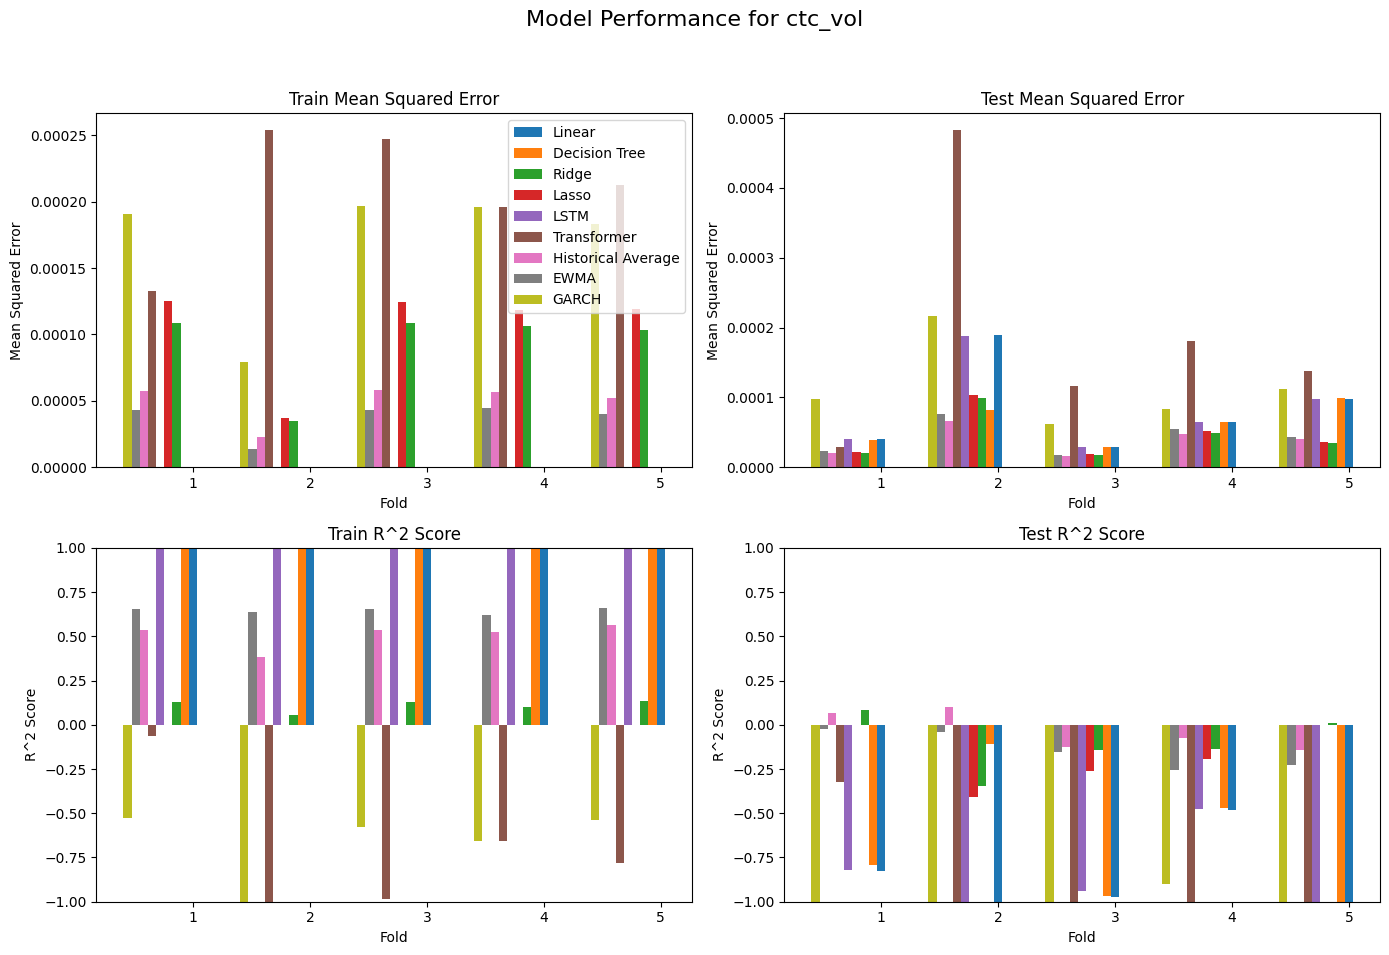

/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Training LSTM: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but sel

parkinson_vol - Linear Average Train Errors: 1.2099060446295464e-33
parkinson_vol - Linear Average Test Errors: 1.9813978993066195e-05
parkinson_vol - Linear Average Train R^2 Scores: 1.0
parkinson_vol - Linear Average Test R^2 Scores: -0.09617796252620417
parkinson_vol - Decision Tree Average Train Errors: 0.0
parkinson_vol - Decision Tree Average Test Errors: 1.1462517975479272e-05
parkinson_vol - Decision Tree Average Train R^2 Scores: 1.0
parkinson_vol - Decision Tree Average Test R^2 Scores: 0.15118990417143965
parkinson_vol - Ridge Average Train Errors: 3.182706781584026e-05
parkinson_vol - Ridge Average Test Errors: 2.0901101542393782e-05
parkinson_vol - Ridge Average Train R^2 Scores: 0.08055647260266259
parkinson_vol - Ridge Average Test R^2 Scores: -0.1760464073695302
parkinson_vol - Lasso Average Train Errors: 3.4970691978353e-05
parkinson_vol - Lasso Average Test Errors: 2.222668546056215e-05
parkinson_vol - Lasso Average Train R^2 Scores: 0.0
parkinson_vol - Lasso Average 

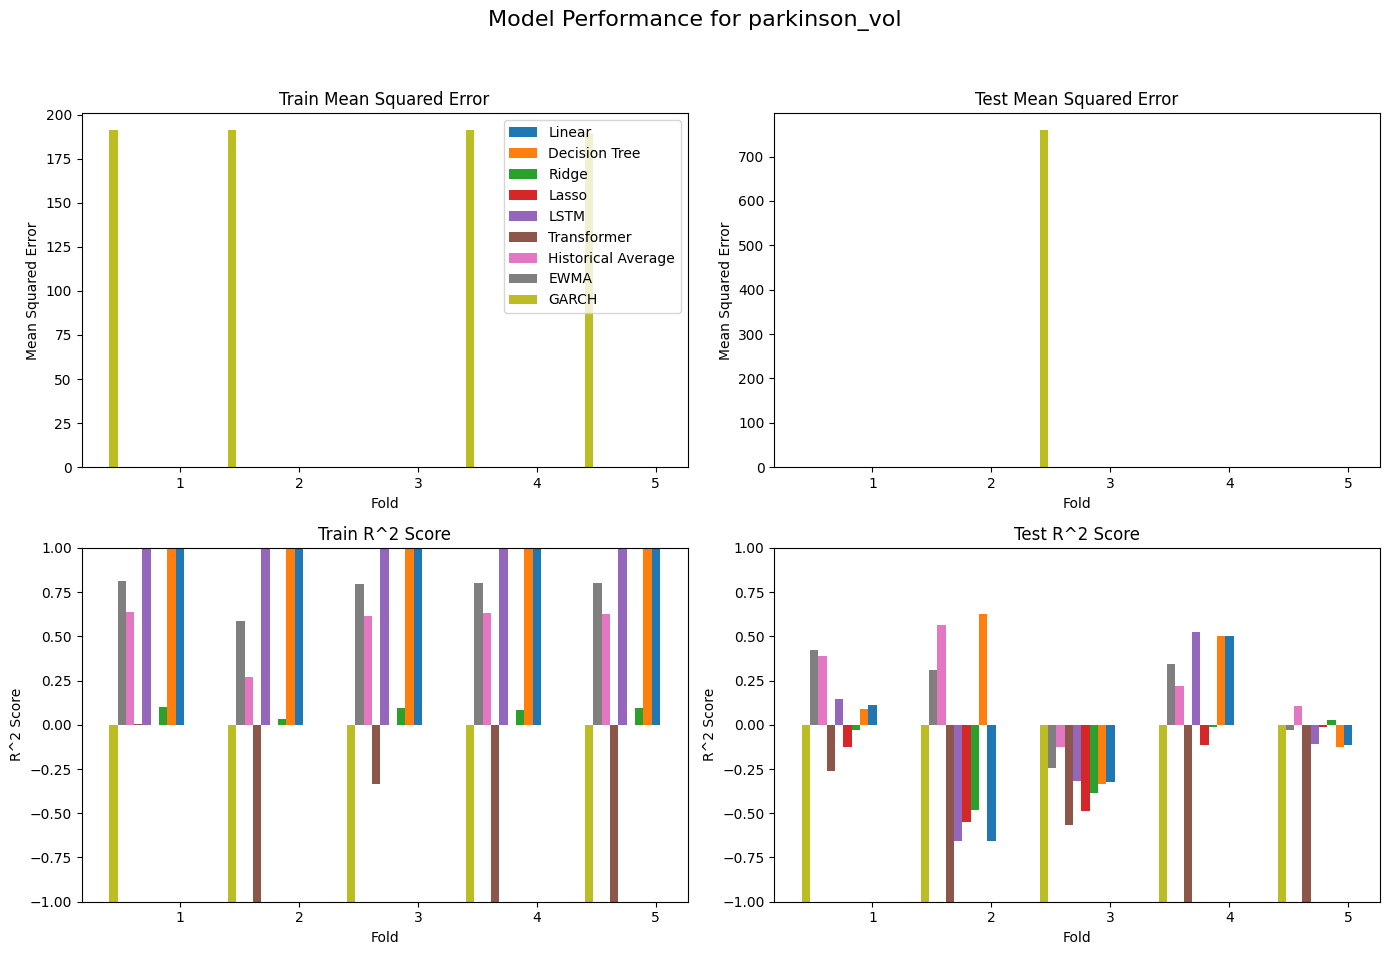

/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize

garman_klass_vol - Linear Average Train Errors: 3.40327840220207e-33
garman_klass_vol - Linear Average Test Errors: 2.5939037952622243e-05
garman_klass_vol - Linear Average Train R^2 Scores: 1.0
garman_klass_vol - Linear Average Test R^2 Scores: -0.1359357091034453
garman_klass_vol - Decision Tree Average Train Errors: 0.0
garman_klass_vol - Decision Tree Average Test Errors: 1.346083159157555e-05
garman_klass_vol - Decision Tree Average Train R^2 Scores: 1.0
garman_klass_vol - Decision Tree Average Test R^2 Scores: 0.2102392150464175
garman_klass_vol - Ridge Average Train Errors: 3.932210340701804e-05
garman_klass_vol - Ridge Average Test Errors: 2.443383687215733e-05
garman_klass_vol - Ridge Average Train R^2 Scores: 0.09598121535343913
garman_klass_vol - Ridge Average Test R^2 Scores: -0.16717387476902296
garman_klass_vol - Lasso Average Train Errors: 4.403034876322626e-05
garman_klass_vol - Lasso Average Test Errors: 2.6343263821496935e-05
garman_klass_vol - Lasso Average Train R^2

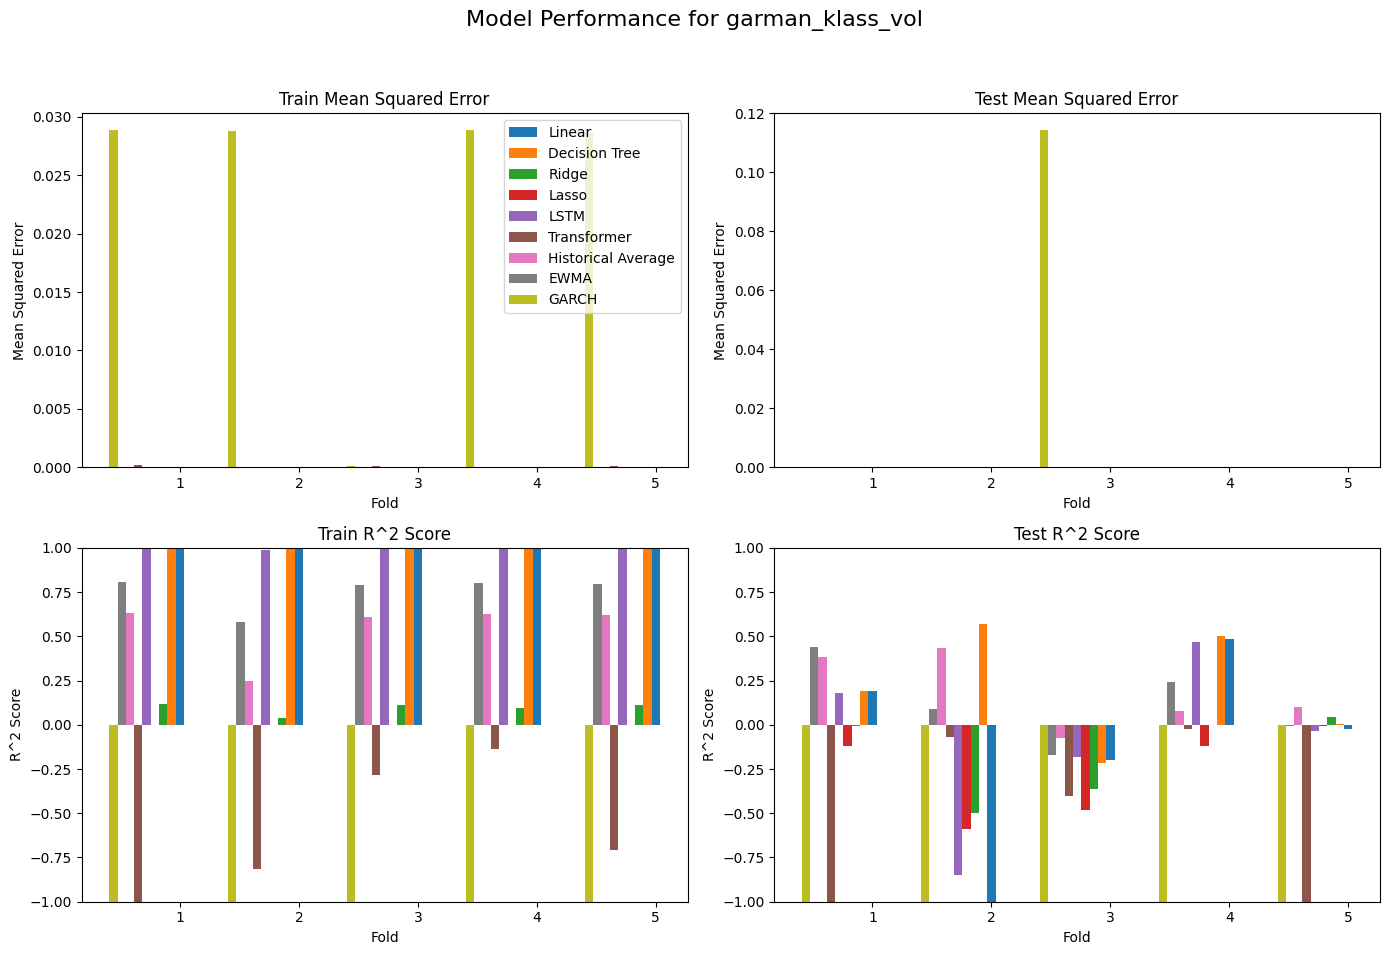

/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See sci

rogers_satchell_vol - Linear Average Train Errors: 4.36586124960324e-34
rogers_satchell_vol - Linear Average Test Errors: 3.461000684056051e-05
rogers_satchell_vol - Linear Average Train R^2 Scores: 1.0
rogers_satchell_vol - Linear Average Test R^2 Scores: -0.8399276037072095
rogers_satchell_vol - Decision Tree Average Train Errors: 0.0
rogers_satchell_vol - Decision Tree Average Test Errors: 2.0674336312456652e-05
rogers_satchell_vol - Decision Tree Average Train R^2 Scores: 1.0
rogers_satchell_vol - Decision Tree Average Test R^2 Scores: -0.29772176397563044
rogers_satchell_vol - Ridge Average Train Errors: 2.4528470180647237e-05
rogers_satchell_vol - Ridge Average Test Errors: 1.7212491958572584e-05
rogers_satchell_vol - Ridge Average Train R^2 Scores: 0.042761881701404866
rogers_satchell_vol - Ridge Average Test R^2 Scores: -0.10216518896259011
rogers_satchell_vol - Lasso Average Train Errors: 2.5736685924157712e-05
rogers_satchell_vol - Lasso Average Test Errors: 1.758899166297702

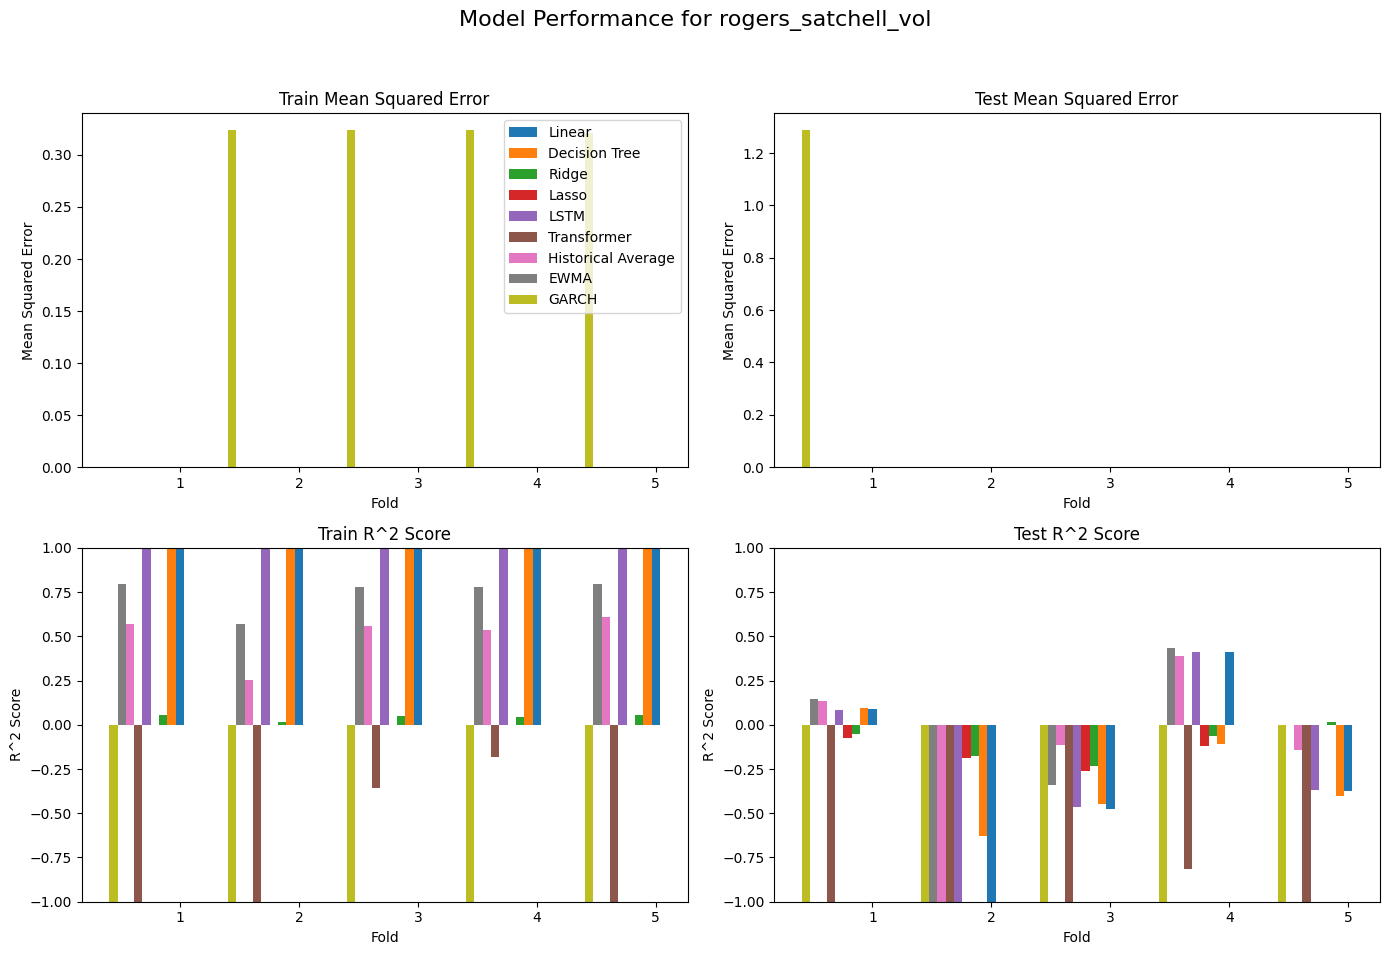

/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Training LSTM: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Training Transformer: 100%|██████████| 50/50 [00:37<00:00,  1.35it/s]
/Users/johnwu/.pyenv/versions/3.9.1/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible

yang_zhang_vol - Linear Average Train Errors: 2.4212111669158173e-34
yang_zhang_vol - Linear Average Test Errors: 3.178120528501552e-05
yang_zhang_vol - Linear Average Train R^2 Scores: 1.0
yang_zhang_vol - Linear Average Test R^2 Scores: -0.9163147043335039
yang_zhang_vol - Decision Tree Average Train Errors: 0.0
yang_zhang_vol - Decision Tree Average Test Errors: 1.8531605329622618e-05
yang_zhang_vol - Decision Tree Average Train R^2 Scores: 1.0
yang_zhang_vol - Decision Tree Average Test R^2 Scores: -0.18995156199642316
yang_zhang_vol - Ridge Average Train Errors: 3.261470376386014e-05
yang_zhang_vol - Ridge Average Test Errors: 1.843001041502997e-05
yang_zhang_vol - Ridge Average Train R^2 Scores: 0.04328718799194249
yang_zhang_vol - Ridge Average Test R^2 Scores: -0.23712228965991042
yang_zhang_vol - Lasso Average Train Errors: 3.42111787067582e-05
yang_zhang_vol - Lasso Average Test Errors: 1.8892209113887093e-05
yang_zhang_vol - Lasso Average Train R^2 Scores: 0.0
yang_zhang_vol

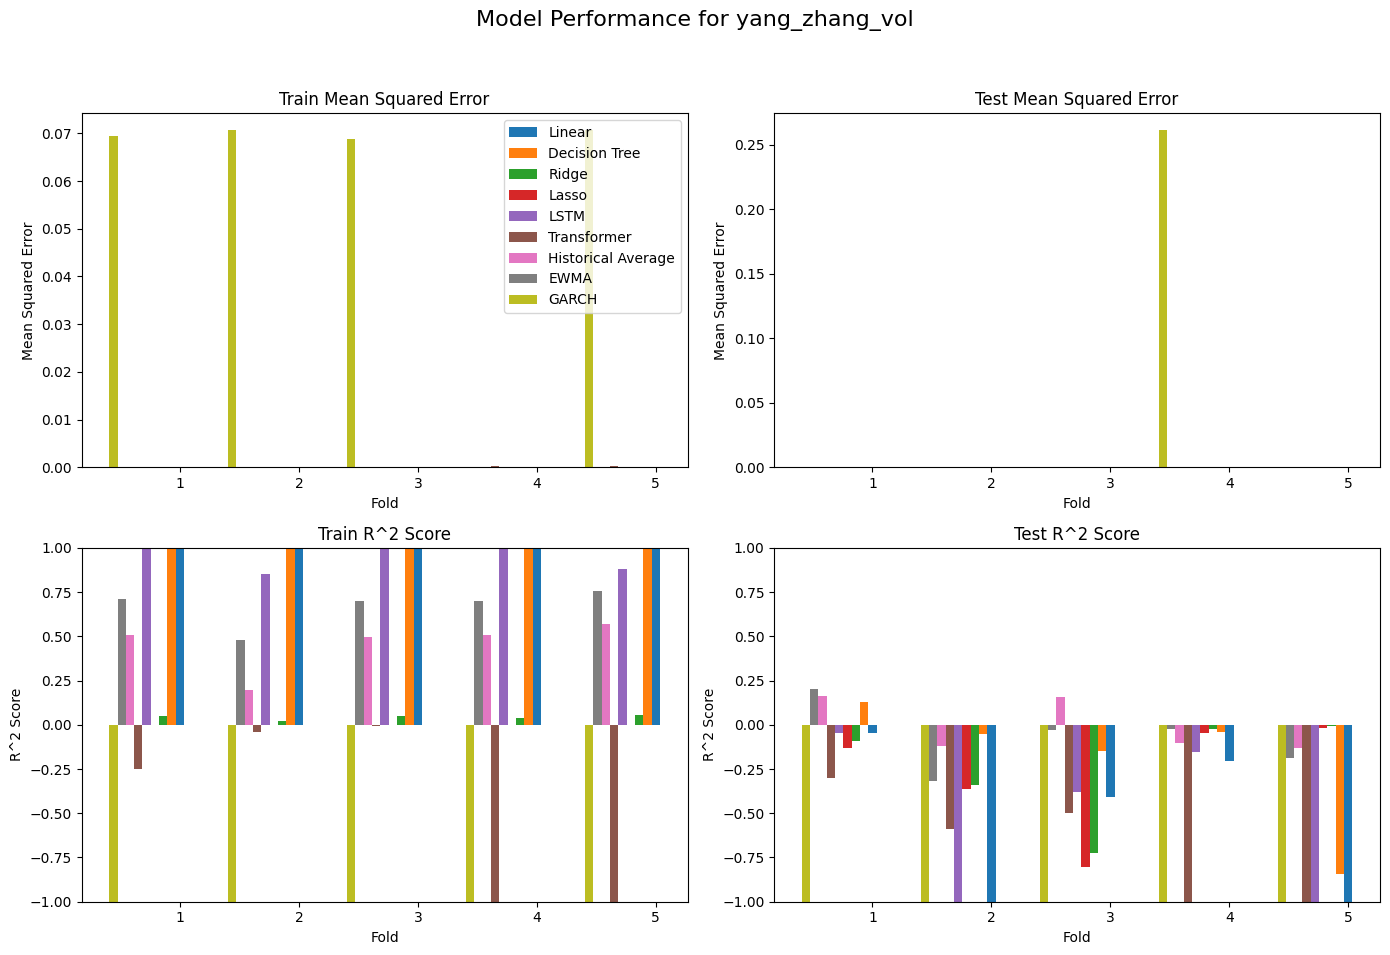

In [34]:
with open('data/time_series_folds.pkl', 'rb') as f:
    final_folds = pickle.load(f)

imputer = SimpleImputer(strategy='constant', fill_value=0)
volatility_metrics = ['ctc_vol', 'parkinson_vol', 'garman_klass_vol', 'rogers_satchell_vol', 'yang_zhang_vol']

models = {
    'Linear': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Ridge': Ridge(), 
    'Lasso': Lasso(), 
    'LSTM': train_lstm,
    'Transformer': train_transformer
}

for vol_metric in volatility_metrics:
    results = {name: {'train_errors': [], 'test_errors': [], 'train_r2': [], 'test_r2': []} for name in models.keys()}
    results.update({'Historical Average': {'train_errors': [], 'test_errors': [], 'train_r2': [], 'test_r2': []},
                    'EWMA': {'train_errors': [], 'test_errors': [], 'train_r2': [], 'test_r2': []},
                    'GARCH': {'train_errors': [], 'test_errors': [], 'train_r2': [], 'test_r2': []}
                    })

    for train_folds, test_folds in final_folds:
        X_train_list = [fold[0][vol_metric].values.flatten() for fold in train_folds]
        y_train_list = [fold[0][vol_metric].values[-1] for fold in train_folds]
        X_test_list = [fold[0][vol_metric].values.flatten() for fold in test_folds]
        y_test_list = [fold[1][vol_metric].values[-1] for fold in test_folds]

        X_train = np.array(X_train_list)
        y_train = np.array(y_train_list)
        X_test = np.array(X_test_list)
        y_test = np.array(y_test_list)

        X_train = imputer.fit_transform(X_train)
        X_test = imputer.transform(X_test)

        non_nan_indices_train = ~np.isnan(y_train)
        X_train = X_train[non_nan_indices_train]
        y_train = y_train[non_nan_indices_train]

        non_nan_indices_test = ~np.isnan(y_test)
        X_test = X_test[non_nan_indices_test]
        y_test = y_test[non_nan_indices_test]

        # HIST Model
        y_pred_train_ha = historical_average(X_train)
        y_pred_test_ha = historical_average(X_test)
        ha_train_error = mean_squared_error(y_train, y_pred_train_ha)
        ha_test_error = mean_squared_error(y_test, y_pred_test_ha)
        ha_train_r2 = r2_score(y_train, y_pred_train_ha)
        ha_test_r2 = r2_score(y_test, y_pred_test_ha)
        results['Historical Average']['train_errors'].append(ha_train_error)
        results['Historical Average']['test_errors'].append(ha_test_error)
        results['Historical Average']['train_r2'].append(ha_train_r2)
        results['Historical Average']['test_r2'].append(ha_test_r2)

        # EWMA Model
        y_pred_train_ewma = ewma(pd.DataFrame(X_train.T)).values
        y_pred_test_ewma = ewma(pd.DataFrame(X_test.T)).values
        # print(len(y_pred_train_ewma), len(y_pred_test_ewma))
        ewma_train_error = mean_squared_error(y_train, y_pred_train_ewma)
        ewma_test_error = mean_squared_error(y_test, y_pred_test_ewma)
        ewma_train_r2 = r2_score(y_train, y_pred_train_ewma)
        ewma_test_r2 = r2_score(y_test, y_pred_test_ewma)
        results['EWMA']['train_errors'].append(ewma_train_error)
        results['EWMA']['test_errors'].append(ewma_test_error)
        results['EWMA']['train_r2'].append(ewma_train_r2)
        results['EWMA']['test_r2'].append(ewma_test_r2)

        # GARCH Model
        try:
            SCALE = 1
            y_pred_train_garch = fit_garch(SCALE * X_train) / SCALE
            y_pred_test_garch = fit_garch(SCALE * X_test) / SCALE
            garch_train_error = mean_squared_error(y_train, y_pred_train_garch)
            garch_test_error = mean_squared_error(y_test, y_pred_test_garch)
            garch_train_r2 = r2_score(y_train, y_pred_train_garch)
            garch_test_r2 = r2_score(y_test, y_pred_test_garch)
            results['GARCH']['train_errors'].append(garch_train_error)
            results['GARCH']['test_errors'].append(garch_test_error)
            results['GARCH']['train_r2'].append(garch_train_r2)
            results['GARCH']['test_r2'].append(garch_test_r2)
        except:
            results['GARCH']['train_errors'].append(np.nan)
            results['GARCH']['test_errors'].append(np.nan)
            results['GARCH']['train_r2'].append(np.nan)
            results['GARCH']['test_r2'].append(np.nan)

        for name, model in models.items():
            if name == 'LSTM':
                y_pred_train, y_pred_test = train_lstm(X_train, y_train, X_test)
            elif name == 'Transformer':
                y_pred_train, y_pred_test = train_transformer(X_train, y_train, X_test)
            else:
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)

            train_error = mean_squared_error(y_train, y_pred_train)
            test_error = mean_squared_error(y_test, y_pred_test)
            train_r2 = r2_score(y_train, y_pred_train)
            test_r2 = r2_score(y_test, y_pred_test)

            results[name]['train_errors'].append(train_error)
            results[name]['test_errors'].append(test_error)
            results[name]['train_r2'].append(train_r2)
            results[name]['test_r2'].append(test_r2)

    for name, result in results.items():
        print(f"{vol_metric} - {name} Average Train Errors: {np.mean(result['train_errors'])}")
        print(f"{vol_metric} - {name} Average Test Errors: {np.mean(result['test_errors'])}")
        print(f"{vol_metric} - {name} Average Train R^2 Scores: {np.mean(result['train_r2'])}")
        print(f"{vol_metric} - {name} Average Test R^2 Scores: {np.mean(result['test_r2'])}")

    folds = list(range(1, len(final_folds) + 1))
    bar_width = 0.07

    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Model Performance for {vol_metric}', fontsize=16)

    for i, (metric, ylabel) in enumerate([('train_errors', 'Mean Squared Error'), ('train_r2', 'R^2 Score')]):
        for j, (name, result) in enumerate(results.items()):
            axs[i, 0].bar(np.arange(len(folds)) - bar_width * j, result[metric], bar_width, label=name)
            axs[i, 1].bar(np.arange(len(folds)) - bar_width * j, result[f'test_{metric[6:]}'], bar_width, label=name)

        axs[i, 0].set_xlabel('Fold')
        axs[i, 0].set_ylabel(ylabel)
        axs[i, 0].set_title(f'Train {ylabel}')
        axs[i, 0].set_xticks(np.arange(len(folds)))
        axs[i, 0].set_xticklabels(folds)
        

        axs[i, 1].set_xlabel('Fold')
        axs[i, 1].set_ylabel(ylabel)
        axs[i, 1].set_title(f'Test {ylabel}')
        axs[i, 1].set_xticks(np.arange(len(folds)))
        axs[i, 1].set_xticklabels(folds)
        

        if i == 0:
            axs[i, 0].legend()
    axs[1, 0].set_ylim(bottom=-1, top = 1)
    axs[1, 1].set_ylim(bottom=-1, top = 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()